In [1]:
import pandas as pd
import numpy as np

In [11]:
import fnmatch 
import os 
  
pattern = 'revs_*.csv'
print('Pattern :', pattern )
  
files = os.listdir('../data/small_dataset/') 
dfs_files = []
for name in files: 
    if fnmatch.fnmatch(name, pattern):
        dfs_files.append(name)
dfs_files
dfs_paths = []
for file in dfs_files:
    dfs_paths.append('../data/small_dataset/' + file)

Pattern : revs_*.csv


In [37]:
revs_dfs = []
for file in dfs_paths:
    revs_dfs.append(pd.read_csv(file))
    
revs_df = pd.concat(revs_dfs)

revs_df['UserID'] = revs_df.user_link.astype('category').cat.codes

revs_df.info()

revsdf = revs_df[['isbn','UserID','ranking']]

reviews_df = revsdf.rename(columns={"ranking":"Rating", 'isbn':'ISBN'})

In [68]:
#droping raws with UserID == 0
reviews_df.drop(reviews_df[reviews_df['UserID']==0].index, axis=0,inplace=True)
reviews_df.drop(reviews_df[reviews_df['Rating']==0].index, axis=0,inplace=True)

In [84]:
reviews_df['ISBN'].value_counts()

1984819194    75
385539304     75
965900584     75
60556579      75
385495323     75
              ..
142003344      8
143036556      8
393348741      8
544272994      8
802714625      8
Name: ISBN, Length: 93, dtype: int64

In [108]:
reviews_df.describe()

,UserID,Rating
count,4406.000000,4406.000000
mean,6913.781207,3.960508
std,4002.581711,1.027558
min,5.000000,1.000000
25%,3527.000000,3.000000
50%,6845.000000,4.000000
75%,10373.750000,5.000000
max,13928.000000,5.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f853f674790>,
      dtype=object)

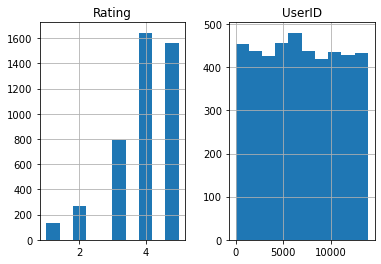

In [109]:
reviews_df.hist()

In [76]:
from surprise import Reader, Dataset, Trainset, accuracy, SVD, SVDpp

from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, \
                                            KNNBaseline, SVDpp, SlopeOne, \
                                            NMF, NormalPredictor, KNNWithZScore, \
                                            BaselineOnly, CoClustering, SVD
from surprise.model_selection import cross_validate, train_test_split, \
                                    GridSearchCV, RandomizedSearchCV

In [72]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(reviews_df[[ 'UserID', 'ISBN', 'Rating']], reader)

In [73]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), \
                  KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), \
                  BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.986131,0.163936,0.007644
KNNBaseline,0.989089,0.173621,0.026491
SVDpp,0.989337,0.289333,0.009395
BaselineOnly,0.990057,0.007375,0.007544
KNNBasic,1.034947,0.124970,0.014594
CoClustering,1.045563,0.305577,0.006406
KNNWithZScore,1.046234,0.208522,0.015774
KNNWithMeans,1.048405,0.150000,0.015580
SlopeOne,1.055660,0.023571,0.008190


In [91]:
reviews_df

,ISBN,UserID,Rating
20,802714625,7241,5.0
21,802714625,835,4.0
23,802714625,1502,4.0
26,802714625,3855,4.0
28,802714625,8156,5.0
...,...,...,...
26,399184414,3267,2.0
28,399184414,6287,4.0
38,399184414,6536,2.0
39,399184414,11584,5.0


In [77]:
trainset, testset = train_test_split(data, test_size=0.2)

In [111]:
algorithm = SVD
param_grid = {'n_factors':[10, 15, 20, 25, 30], 'n_epochs': [5,10, 15, 20]} #
gs = RandomizedSearchCV(algorithm, param_grid, measures=['rmse', 'mae'], n_iter=3, cv=2)
gs.fit(data)
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9905995506979174
{'n_factors': 20, 'n_epochs': 15}


In [ ]:
gs.cv_results

In [ ]:
# We can now use the algorithm that yields the best rmse:
algo = gs.best_estimator['rmse']
algo.fit(data.build_full_trainset())

In [ ]:
algorythm = SVD()
param_grid = {'n_epochs': [5,10], 'n_factors':[15, 20]}
gs = RandomizedSearchCV(algorythm, param_grid, measures=['rmse', 'mae'], cv=2)
gs.fit(data)
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])